![montage](./montage_mri_final.png)

## Quantitative T1 MRI using Python

## Model: $$ S = Mz * (1 - e^{ (TR / T1 )} )$$

## Objetive: 
- Estimate `T1` and `Mz` for all voxels in the data


## Metadata
- TR (msec) =  508.2336 1000 1500 2500 3500 4500 5500 6500
- Rows = 128
- Cols = 128
- Total images = 168
- Slices = 21  

## Sample:
- Lime

## source:
- Data.World ([@julio](https://data.world/julio/learn-quantitative-mri))




In [1]:
# modules
using DataFrames
using PyPlot
using LsqFit

In [2]:
# load data
df = readtable("T1Lemon.csv", header = false);
MRI_2D = convert(Array, df[2:end]);

# define variables
TR = [508.2336 ,1000 ,1500 ,2500 ,3500 ,4500 ,5500 ,6500];
TR = TR / 1000;
Total_Slices = 21

# model function
T1rec(x_, p) = p[1]*(1-exp(-x_/p[2]))

# goodness of fit
function r_squared(Yobserved, Ypredicted)
    ssres = sum((Yobserved - Ypredicted).^2)
    tss = sum((Yobserved - mean(Ypredicted)).^2)
    rsq = 1 - (ssres/tss)
    return rsq
end

# fitting function
function fitT1(ydata)
    # normalize
    ydata= ydata / ydata[end]
    #fit
    fit = curve_fit(T1rec, TR, ydata, [1.0, 2.0]);
    T1  = fit.param[2]
    # evaluate fitting
    yhat = T1rec(TR, fit.param);
    RSQ  = r_squared(ydata, yhat)
    return T1, RSQ
end

# mapping function
function T1map(DataMatrix, Slice = 1)
I = DataMatrix[:,Slice:21:end];
rows, cols = size(DataMatrix)
T1 = zeros(rows)    
RSQ = zeros(rows) 
    for i = 1:rows
        T1[i], RSQ[i] = fitT1(I[i,:]);
    end
    return reshape(T1,128, 128), reshape(RSQ,128, 128)
end

T1map (generic function with 2 methods)

In [10]:
I = MRI_2D[:,1:21:end];
@time t1, rsq = fitT1(I[10000,:])

  0.000126 seconds (630 allocations: 69.328 KB)


(1.9444986403825835,0.9960386255424681)

# Process all 16384 voxels

In [9]:
@time map_T1, map_rsq = T1map(MRI_2D, 1);

  1.914255 seconds (18.01 M allocations: 1.907 GB, 9.16% gc time)


## T1 map 

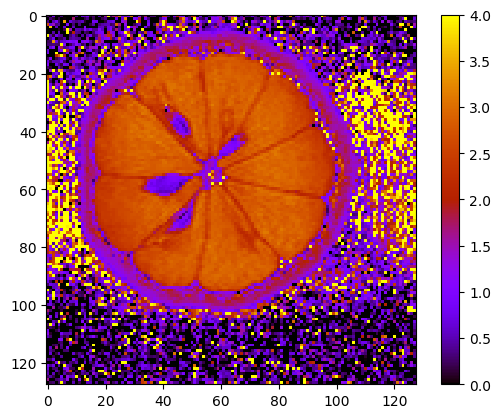

In [5]:
imshow(map_T1, cmap = "gnuplot", vmin = 0, vmax= 4); PyPlot.colorbar();

# Process  6789 voxels with SNR > 20

In [6]:
function T1mapV2(DataMatrix, Slice = 1)
I = DataMatrix[:,Slice:21:end];
rows, cols = size(DataMatrix)
T1 = zeros(rows)    
RSQ = zeros(rows) 
SNR_FILTER = I[:,1] / std( DataMatrix[1,:])

    
    for i = 1:rows
        if SNR_FILTER[i] > 20
        T1[i], RSQ[i] = fitT1(I[i,:]);
        else
        T1[i], RSQ[i] = 0, 0
        end
    end
    
    return reshape(T1,128, 128), reshape(RSQ,128, 128), SNR_FILTER
end

T1mapV2 (generic function with 2 methods)

In [7]:
@time map_T1, map_, f= T1mapV2(MRI_2D, 1);

  0.663260 seconds (4.40 M allocations: 464.828 MB, 7.28% gc time)


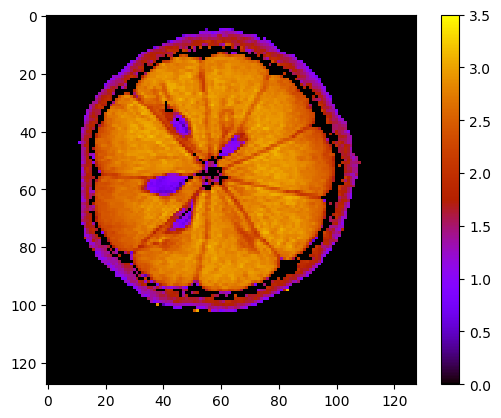

In [8]:
imshow(map_T1, cmap = "gnuplot", vmin = 0, vmax= 3.5); PyPlot.colorbar();